# Layout Analysis Dataset

In [21]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
import xml.etree.ElementTree as ET
import csv
import matplotlib.pyplot as plt
from planar import BoundingBox
import torch
import torch.nn as nn
from torch.utils import data
from PIL import Image

In [2]:
#total classes of Layout Analysis Dataset
class_dict={'TextRegion':0,'ImageRegion':1,'LineDrawingRegion':2,'GraphicRegion':3,'TableRegion':4,'ChartRegion':5,
           'SeparatorRegion':6,'MathsRegion':7,'NoiseRegion':8,'FrameRegion':9,'UnknownRegion':10}

In [3]:
#copy dataset to working directory
os.getcwd()
sub_dataset_location=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/'
images_location=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/Images'
annotations_location=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/XML'
csv_file=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/main_data.csv'
csv_location=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/CSV/'
#example image to check image and given annotation
example_image=images_location+'/00000406.tif'
example_xml=annotations_location+'/00000406.xml'

In [22]:
def XMLs_to_csv(xml_folder_location):
    main_df=pd.DataFrame()
    csv_location=os.getcwd()+'/PRImA Layout Analysis Dataset/PRImA Layout Analysis Dataset/CSV'
    if not os.path.exists(csv_location):
        os.makedirs(csv_location)
        print("Directory " , csv_location ,  " Created ")
    xml_list=[]
    img_list=[]
    for xml_file in list(sorted(os.listdir(xml_folder_location))):
        xml_list.append(xml_file)
        if not os.path.exists(csv_location):
            os.makedirs(csv_location)

        
        current_xml=xml_folder_location+'/'+xml_file
        if current_xml.split('/')[-1][:3]=='pc-':
            split_name=current_xml.split('/')[-1].split('-')[-1].split('.')[0]
        else:
            split_name=current_xml.split('/')[-1].split('.')[0]
        
        
        just_csv_name=''.join(split_name)+'.csv'
        csv_name=csv_location+'/'+just_csv_name
        just_image_name=''.join(split_name)+'.tif'
        image_name=images_location+'/'+just_image_name
        
        img_list.append(just_image_name)
        
        

        pre_csv_dict={}
        tree = ET.parse(current_xml)
        root = tree.getroot()
        for child in root:
            
            if child.tag.split('}')[1]=='Page':
                pre_csv_dict=child.attrib
                pre_csv_dict.update({'imgLocation':image_name,'BBox_csv_Location':csv_name})
                
                main_df=main_df.append(pre_csv_dict,ignore_index=True)
                
                class_list=[]
                class_coords_list=[]
                count=0
                for sub_child in child:
                    if sub_child.tag.split('}')[1] in class_dict.keys():
                        running_class_list=[]
                        for annot in sub_child:
                            for coords in annot:
                                running_class_list.append(coords.attrib)
                            if len(running_class_list)>3:
                                class_coords_list.append(running_class_list)
                                class_list.append(sub_child.tag.split('}')[1])
                pre_bbox_list=[]
                for coords in class_coords_list:
                    temp_bbox_list=[]
                    for points in coords:
                        x=int(points['x'])
                        y=int(points['y'])
                        tup=(x,y)
                        temp_bbox_list.append(tup)
                    pre_bbox_list.append(temp_bbox_list)

                xmin_list,ymin_list,xmax_list,ymax_list=[],[],[],[]
                for coords in pre_bbox_list:

                    temp_bbox_dict={}
                    bbox=BoundingBox(coords)
                    x_min,y_min=int(bbox.min_point[0]),int(bbox.min_point[1])
                    x_max,y_max=int(bbox.max_point[0]),int(bbox.max_point[1])
                    xmin_list.append(x_min)
                    ymin_list.append(y_min)
                    xmax_list.append(x_max)
                    ymax_list.append(y_max)

        
        
        if len(class_list)==len(xmin_list) and len(class_list)==len(ymin_list)  and len(class_list)==len(xmax_list)  and len(class_list)==len(ymax_list):
            csv_df=pd.DataFrame(list(zip(class_list,xmax_list,ymax_list,xmin_list,ymin_list)),
                                columns=['Class','x_max','y_max','x_min','y_min'])
            csv_df.to_csv(csv_name,index=False)
            
        main_df.to_csv(csv_file,index=False)
        


In [23]:
XMLs_to_csv(annotations_location)

In [24]:
df=pd.read_csv(csv_file)
train_size = int(0.8 * len(df))
valid_size = len(df) - train_size
train_data, valid_data = torch.utils.data.random_split(df, [train_size, valid_size])
print(len(train_data))
print(len(valid_data))
df.head(1)

382
96


,BBox_csv_Location,imageFilename,imageHeight,imageWidth,imgLocation
0,/home/heller/Developer/Workplace/TessalateImag...,00000086.tif,3275,2442,/home/heller/Developer/Workplace/TessalateImag...


In [25]:
#function to visualise image from train/valid image
def data_img_plot(data_set,number):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size
    im = plt.imread(data_set.dataset.iloc[number]['imgLocation'])
    implot = plt.imshow(im)
    plt.show()

#function to visualise image from train/valid image with Convex Hull annotation
def data_convex_hull_plot(data_set,number):
    check_1=data_set.dataset.iloc[number]['imgLocation'].split('/')[-1].split('.')[0]+'.xml'

    if os.path.exists(annotations_location+'/'+check_1):
        xml_file=annotations_location+'/'+check_1
    else:
        str1=data_set.dataset.iloc[number]['imgLocation'].split('/')[-1].split('.')[0]
        xml_file=annotations_location+'/pc-'+str1+'.xml'
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for child in root:
        if child.tag.split('}')[1]=='Page':
            pre_csv_dict=child.attrib
            #pre_csv_dict.update({'imgLocation':image_name,'BBox_csv_Location':csv_name})
            class_list=[]
            class_coords_list=[]
            count=0
            for sub_child in child:
                if sub_child.tag.split('}')[1] in class_dict.keys():
                    running_class_list=[]
                    for annot in sub_child:
                        for coords in annot:
                            running_class_list.append(coords.attrib)
                        if len(running_class_list)>3:
                            class_coords_list.append(running_class_list)
                            class_list.append(sub_child.tag.split('}')[1])

    im = plt.imread(data_set.dataset.iloc[number]['imgLocation'])
    implot = plt.imshow(im)
    for coords in class_coords_list:
        for i in range(len(coords)):
            if i== len(coords)-1:
                x1,x2=int(coords[i]['x']),int(coords[0]['x'])
                y1,y2=int(coords[i]['y']),int(coords[0]['y'])
                plt.plot([x1,x2],[y1,y2],'r')
            else:
                x1,x2=int(coords[i]['x']),int(coords[i+1]['x'])
                y1,y2=int(coords[i]['y']),int(coords[i+1]['y'])
                plt.plot([x1,x2],[y1,y2],'r')
    plt.show()

#function to visualise image from train/valid image with bounding box annotation Convex Hull annotation
def data_annot_plot(data_set,number):
    sub_df=pd.read_csv(data_set.dataset.iloc[number]['BBox_csv_Location'])
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 12
    plt.rcParams["figure.figsize"] = fig_size
    im = plt.imread(train_data.dataset.iloc[number]['imgLocation'])


    for i in range(len(sub_df)):
        xmax=sub_df.iloc[i]['x_max']
        ymax=sub_df.iloc[i]['y_max']
        xmin=sub_df.iloc[i]['x_min']
        ymin=sub_df.iloc[i]['y_min']
        plt.plot([xmax,xmax],[ymin,ymax],'r')
        plt.plot([xmax,xmin],[ymax,ymax],'r')
        plt.plot([xmin,xmin],[ymax,ymin],'r')
        plt.plot([xmin,xmax],[ymin,ymin],'r')
    implot = plt.imshow(im)
    plt.show()

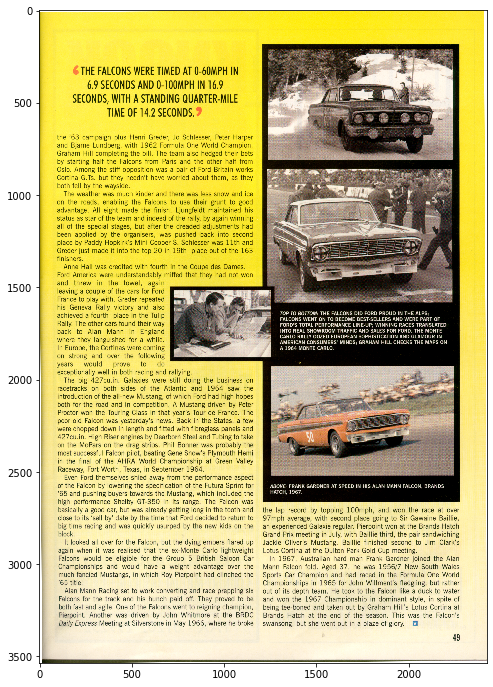

In [32]:
#train_data image number 5
data_img_plot(train_data,7)

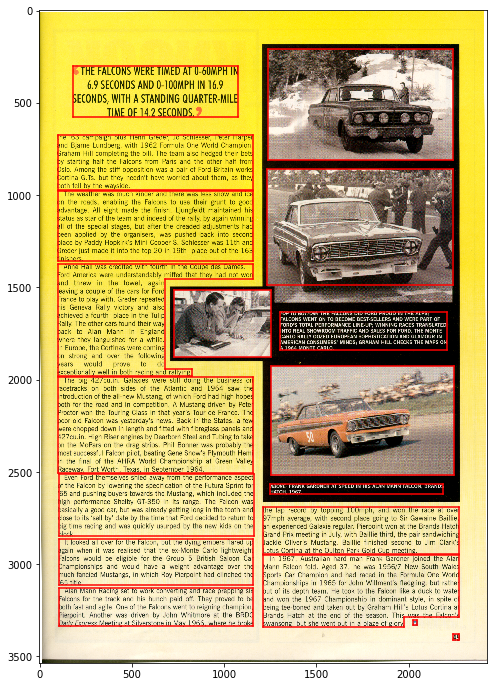

In [33]:
#train_data 5th element image with convex hull annotation
data_convex_hull_plot(train_data,7)

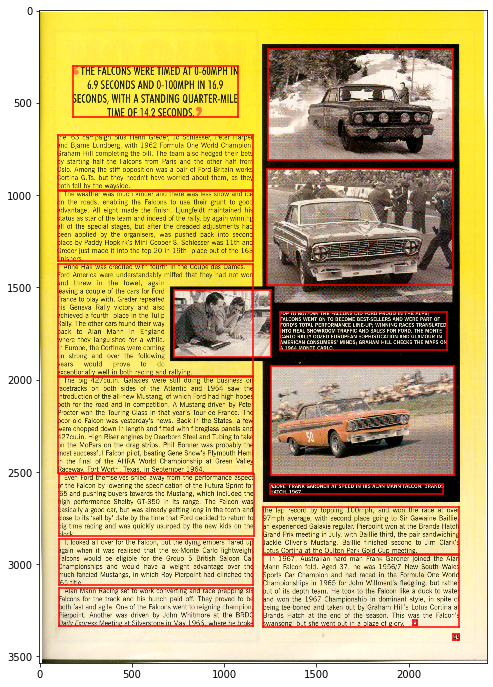

In [34]:
#train_data 5th element with calculated bounding box annotation instead of convex hull annotation
data_annot_plot(train_data,7)

In [ ]:
class LayoutDataset(object):
    def __init__(self,data_csv,transform):
        self.csv=data_csv
        self.transform=transform
        self.img=